In [1]:
import madjax
import numpy as np
import jax
import matplotlib.pyplot as plt

E_CM = 90
mj = madjax.MadJax('ee_to_mumu')
matrix_element = mj.matrix_element(
    E_cm=E_CM, process_name='Matrix_1_mupmum_epem', return_grad=False, do_jit=False
)
phasespace = mj.phasespace_vectors(E_cm=E_CM, process_name='Matrix_1_mupmum_epem')

FIXED_SAMPLE = np.random.uniform(0, 1, size=(100, 2))
KEY = jax.random.PRNGKey(0)

## Mining Gold with MadJax

In [2]:
def scalar_me(par_random):
    par = par_random[0]
    random = par_random[1:]
    pars = {
        ("sminputs", 2): par * 1e-05,  # 1.166390 # fermi constant
    }
    return matrix_element(pars, random)


vector_me = jax.jit(jax.vmap(scalar_me))

In [3]:
def integral_and_max_scalar(p, fixed_sample):
    inp = jax.numpy.concatenate(
        [p * np.ones((len(fixed_sample), 1)), fixed_sample], axis=1
    )
    v = vector_me(inp)
    integ1 = np.sum(v) / len(fixed_sample)
    return integ1, jax.numpy.max(v)


def scalar_pdf(par_random, integration_sample):
    par = par_random[0]
    integ, maxv = integral_and_max_scalar(par, integration_sample)
    me = scalar_me(par_random)
    accept_proba = me / maxv
    return me / integ, accept_proba


def scalar_pdf_precomp(par_random, precomp_index=0):
    par = par_random[0]
    integ, maxv = precomp[precomp_index]
    me = scalar_me(par_random)
    accept_proba = me / maxv
    return me / integ, accept_proba

In [13]:
def scalar_sim(ps_variables, key):
    v = phasespace({}, random_variables=ps_variables)

    final_state = v[-2:]

    sigmas = 13
    shift = jax.random.normal(key, shape=final_state.shape) * sigmas

    smeared = final_state + shift

    angles = smeared[:, 3] / jax.numpy.sqrt(np.sum(smeared[:, 1:] ** 2, axis=1))
    return angles[0]


def fullchain(par_random, refpar, key, integration_sample):
    par = par_random[0]

    ps_variables = par_random[1:]

    ref_par_random = jax.numpy.concatenate([jax.numpy.array([refpar]), ps_variables])

    (pdf, _), grad = jax.value_and_grad(scalar_pdf, has_aux=True)(
        par_random, FIXED_SAMPLE
    )
    pdfref, accept_proba = scalar_pdf(ref_par_random, FIXED_SAMPLE)
    #     pdfref,accept_proba = scalar_pdf_precomp(ref_par_random,precomp_index=0)

    ratio = pdf / pdfref
    score = grad[0] / pdfref

    keyhead, key = jax.random.split(key, 2)
    x = scalar_sim(ps_variables, keyhead)

    accept = jax.random.uniform(key) < accept_proba

    return x, ratio, score, accept


vfullchain = jax.jit(jax.vmap(fullchain, in_axes=(0, None, 0, None)))

In [14]:
print(f'ME eval:', scalar_me(jax.numpy.array([1.5, 0.5, 0.5])))
print(f'pdf eval:', scalar_pdf(jax.numpy.array([1.5, 0.5, 0.5]), FIXED_SAMPLE))
print(f'simulate:', scalar_sim(jax.numpy.array([0.6, 0.5]), KEY))

ME eval: 1.68688280829618
pdf eval: (DeviceArray(0.74652852, dtype=float64), DeviceArray(0.37929971, dtype=float64))
simulate: 0.7682236322147795


In [15]:
print(
    f'fullchain:', fullchain(jax.numpy.array([1.6, 0.6, 0.5]), 1.5, KEY, FIXED_SAMPLE)
)

fullchain: (DeviceArray(0.65170544, dtype=float64), DeviceArray(1.0276153, dtype=float64), DeviceArray(0.25070651, dtype=float64), DeviceArray(False, dtype=bool))


In [16]:
def simulate_batch(key, par_eval='random', par_ref=1.5, Ninit=1000):
    while True:
        # determine phase space points
        key_ps, key = jax.random.split(key)
        ps_points = jax.random.uniform(key_ps, shape=(Ninit, 2))

        # determine parameters to evaluate numerator
        key_par, key = jax.random.split(key)
        if par_eval == 'random':
            par_array = jax.random.uniform(
                key_par, minval=1, maxval=2, shape=(Ninit, 1)
            )
        else:
            par_array = np.ones((Ninit, 1)) * par_eval
        par_random = jax.numpy.concatenate([par_array, ps_points], axis=1)

        key_full, key = jax.random.split(key)
        x, ratio, score, accept = vfullchain(
            par_random, par_ref, jax.random.split(key_full, Ninit), FIXED_SAMPLE
        )

        p = par_random[:, 0][accept]
        x = x[accept]
        ratio = ratio[accept]
        score = score[accept]

        px = jax.numpy.concatenate([p.reshape(-1, 1), x.reshape(-1, 1)], axis=1)
        yield px, ratio, score

In [17]:
from jax.experimental import optimizers
from jax.experimental import stax
from jax.experimental.stax import Dense, Relu, Tanh


def setup_net():
    init_random_params, predict = stax.serial(
        Dense(256), Tanh, Dense(256), Tanh, Dense(1)
    )
    rng = jax.random.PRNGKey(0)
    _, net = init_random_params(rng, (-1, 2))
    return net, predict


class netobj:
    def __init__(self, net, predict):
        self._net = net
        self._predict = predict

        single_infer = lambda xp: self._predict(self._net, xp)[0]
        self.grads = jax.vmap(jax.grad(single_infer))

    def predict(self, x):
        y = self._predict(self._net, x)
        g = self.grads(x)
        return y, g


def loss(net, predict, px, r, t):
    v, g = netobj(net, predict).predict(px)
    l = 0
    l += ((v[:, 0] - r) ** 2).mean()  # direct on ratio
    l += ((g[:, 0] - t) ** 2).mean()  # grad on score
    return l

In [22]:
def plot_small(net, predict, simulator):
    px, r, t = next(simulator)
    pr, pg = netobj(net, predict).predict(px)

    fig, axarr = plt.subplots(1, 2)

    ax = axarr[0]
    ax.scatter(px[:, 1], r)
    ax.scatter(px[:, 1], pr)

    ax = axarr[1]
    ax.scatter(px[:, 1], t)
    ax.scatter(px[:, 1], pg[:, 0])


def plot(net, predict, par_eval=2.0):
    key1, key2, key = jax.random.split(KEY, 3)
    altsim = simulate_batch(key1, par_eval=1.0, par_ref=par_eval, Ninit=2000)
    nulsim = simulate_batch(key2, par_eval=1.0, par_ref=1.5, Ninit=2000)

    simulator = simulate_batch(key, par_eval=par_eval, par_ref=1.5, Ninit=2000)
    px, r, t = next(simulator)
    pr, pg = netobj(net, predict).predict(px)

    fig = plt.figure(constrained_layout=True)
    fig.set_size_inches(7, 16)
    gs = fig.add_gridspec(5, 2)

    ax = fig.add_subplot(gs[0, :])
    bins = np.linspace(-1, 1, 16)
    ctrs = np.diff(bins) / 2 + bins[:-1]
    calt, _, _ = ax.hist(
        next(altsim)[0][:, 1], bins=bins, histtype='step', density=True
    )
    cnul, _, _ = ax.hist(
        next(nulsim)[0][:, 1], bins=bins, histtype='step', density=True
    )
    ax.set_xlim(-1, 1)

    ax = fig.add_subplot(gs[1, :])
    ax.scatter(px[:, 1], pr, alpha=0.2)
    ax.scatter(ctrs, calt / cnul)
    ax.set_ylim(0, 2)
    ax.set_xlim(-1, 1)

    ax = fig.add_subplot(gs[2, 0])
    ax.scatter(px[:, 1], r)
    ax.scatter(px[:, 1], pr)
    ax.set_ylim(0, 2)
    ax.set_ylabel('ratio')

    ax = fig.add_subplot(gs[2, 1])
    ax.scatter(px[:, 1], t)
    ax.scatter(px[:, 1], pg[:, 0])
    ax.set_ylim(-2, 2)
    ax.set_ylabel('score')

    ax = fig.add_subplot(gs[3:, :], projection='3d')

    grid = x, y = np.mgrid[1:2:101j, -1:1:101j]
    mpts = np.swapaxes(grid, 0, -1).reshape(-1, 2)
    pm = predict(net, mpts)
    z = np.swapaxes(pm.reshape(101, 101), 0, -1)
    ax.plot_surface(y, x, z)
    ax.set_xlabel('x')
    ax.set_ylabel('θ')
    ax.set_zlabel('ratio')
    fig.tight_layout()

In [19]:
def train(simulator):
    net, predict = setup_net()
    opt_init, opt_update, get_params = optimizers.adam(1e-3)
    opt_state = opt_init(net)

    @jax.jit
    def update(net, px, r, t, opt_state):
        l, g = jax.value_and_grad(loss)(net, predict, px, r, t)
        opt_state = opt_update(0, g, opt_state)
        return l, opt_state

    for i in range(2000):
        px, r, t = next(simulator)
        l, opt_state = update(net, px, r, t, opt_state)
        net = get_params(opt_state)
        if i % 10 == 0:
            print(l)
        if i % 200 == 0:
            plot_small(net, predict, simulator)
            plt.show()
    return net, predict

1.7111698286525685


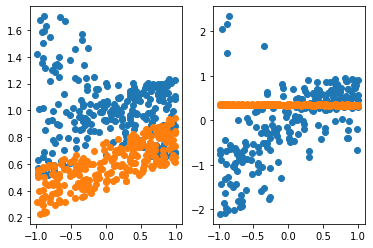

0.9419741291494621
0.6366937434945897
0.7232821957694923
0.5583203821966981
0.536878520579815
0.4525922868496417
0.46246992744016013
0.44098417563629916
0.28061412722846657
0.3123583737685934
0.24707993692835456
0.2623604342264558
0.266464612741471
0.3371773009157099
0.26759099664533764
0.25256360699437874
0.26082612715632875
0.3074963169594061
0.24911675930168242
0.26823760914790545


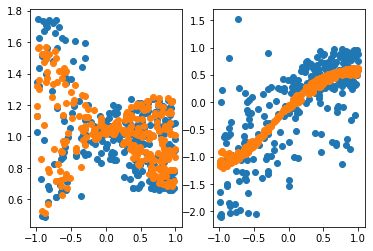

0.2539840660714316
0.31095761623095836
0.2565849881159637
0.19211521511052415
0.24714365814949998
0.2179451832911621
0.22878694951789924
0.31433961536486454
0.20792936056108924
0.29659398390742525
0.21595330021751882
0.20484757176665253
0.23831251664048156
0.24598812138945209
0.21579022853170085
0.27814861241106426
0.2508538284417814
0.3108326446397986
0.27728880555150315
0.26265432784640635


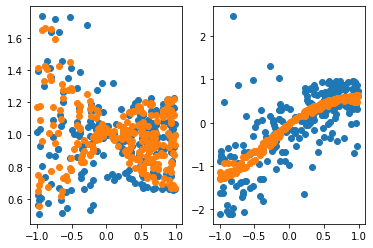

0.24165571126284577
0.38030570372559963
0.26976340571589374
0.2519953274037707
0.2230742815750903
0.24666401183546105
0.22448372058693528
0.2459540303023212
0.16406865940317908
0.2930528406834481
0.2477366235218119
0.21163898259128394
0.3600806622216008
0.3633621994299228
0.20225844998491083
0.2989107820404557
0.2860939430395105
0.25033466799762816
0.4190276862743045
0.22283754105258083


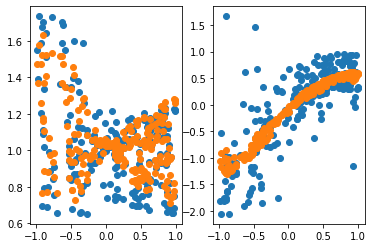

0.1946305821282607
0.24998005780730853
0.19398167496221366
0.3067510568546649
0.22007312872884618
0.2945586425429464
0.18970964577341537
0.2836769010034001
0.19525074817096794
0.24371264177755292
0.21943853268234775
0.23157186998144236
0.22997746715335182
0.18760332668030216
0.2621692035345308
0.3475767154671826
0.16794910277828234
0.22315106599523502
0.18341067283837245
0.2472798020303023


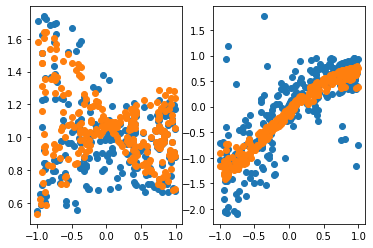

0.272232405187211
0.2258471619818961
0.18886900781884994
0.16534247200009866
0.20459964813123124
0.21384424836013888
0.18279226537580004
0.18672112696982918
0.18426725446759618
0.15650771513628345
0.21416045054264157
0.2055230480411258
0.17809633735250635
0.15712682369514247
0.1632674055638091
0.1662910043295728
0.12409884095750148
0.12596563339820357
0.15190835361550567
0.1680564068771217


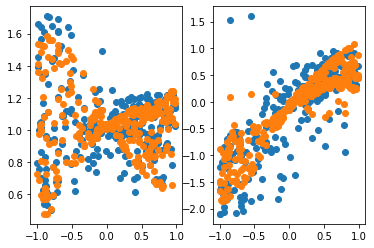

0.1262668461432483
0.1266096424550484
0.11712380433805311
0.1370504453698232
0.1326460515854834
0.1526711427074852
0.1294700028493904
0.11961189749431998
0.10942623498172496
0.11108621815906075
0.07662530773089042
0.11236570259077529
0.13606998347607246
0.0989844595491609
0.1442868427604141
0.11099497763533313
0.10208569376474753
0.1437375063403457
0.11452601564667188
0.11019606714777753


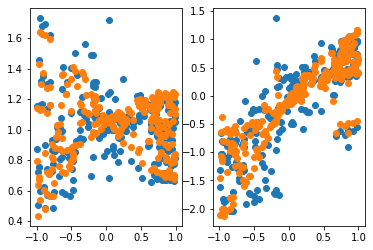

0.11064691354163604
0.10725013807126904
0.10893695675734484
0.11412161487116322
0.11152490410796327
0.10639974532865858
0.11370943092108073
0.10572703086671342
0.1181529556479766
0.08976557700390642
0.08805560400314921
0.12295493497219707
0.10070369927719976
0.09250185929944935
0.12432420702524004
0.08010496839067506
0.10195904023726676
0.08775297105889375
0.08591000877250964
0.08481134587320953


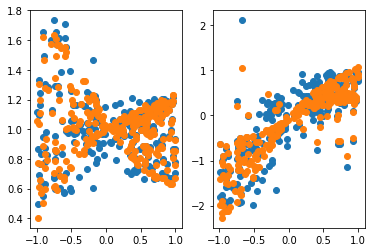

0.11977555526505439
0.09779919594052881
0.07937287096382913
0.12310149151767769
0.09928895379872078
0.10352328023925432
0.10318179756234247
0.07519823834199471
0.1322106443976292
0.09141491835483011
0.09224204174216394
0.1013918140698079
0.09525464164400615
0.10211350463428574
0.10094730794365561
0.11364173043801441
0.11709339597500311
0.11434217044263144
0.0952181326116632
0.05967187661816903


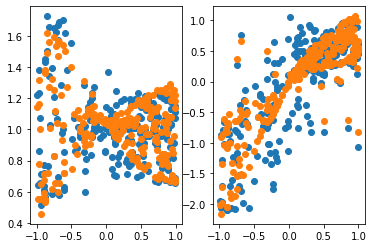

0.07647500424484842
0.08967629814183137
0.09075838347204403
0.11474253863191301
0.0997610916174849
0.10118886403255524
0.11629812970480587
0.13782365494653212
0.106004641001962
0.1093278456454821
0.10256321225842685
0.09471236834614018
0.08449813957966373
0.11385457678869658
0.09391146274902779
0.14208005784478878
0.11428028192669412
0.09540276403759028
0.1434605360801763
0.11034987227978788


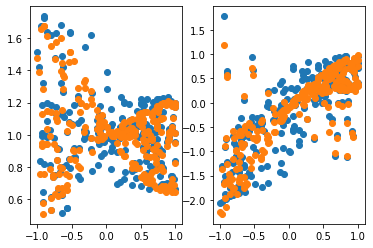

0.08260857341878318
0.13228408893351953
0.1236548351815514
0.10137633067859766
0.08711438779028632
0.10016688263950617
0.08867028481919596
0.08317925850324037
0.13118769461090504
0.12020328275043139
0.07515515920122134
0.1265069618268497
0.09065168684486036
0.11629583514695373
0.12195218908917774
0.12239341157001578
0.10785972101186618
0.08420837689458532
0.09328701989790905


In [20]:
simulator = simulate_batch(KEY, par_eval='random', par_ref=1.5, Ninit=500)
n, p = train(simulator)

/Users/lukasheinrich/Code/madjax/devenv/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


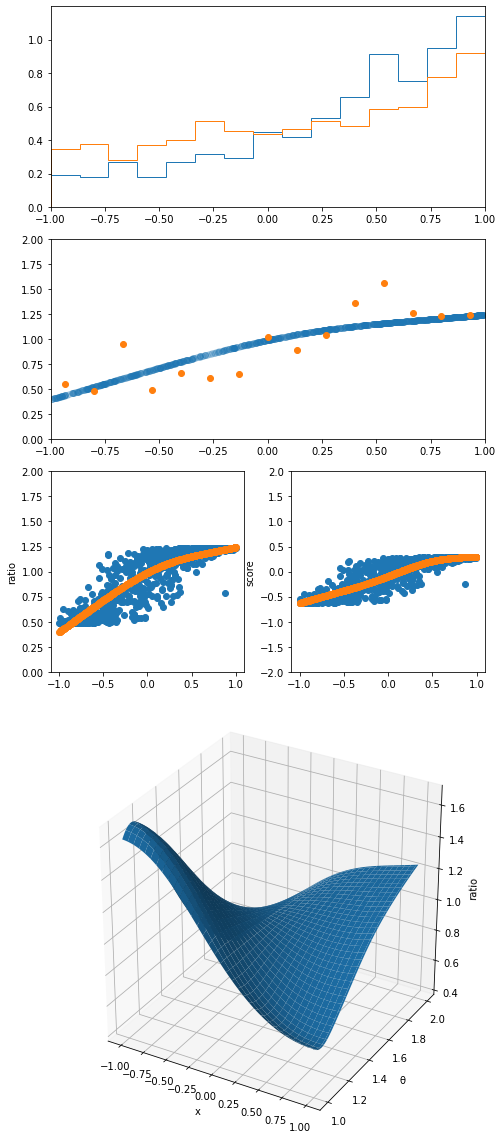

In [25]:
plot(n, p, par_eval=2.0)